# ドローン画像を用いた草本の表現型定量

## ライセンス
- 論文　https://onlinelibrary.wiley.com/doi/full/10.1002/ece3.6861
    - CC-BY 4.0
- 公式レポジトリ https://github.com/oceam/WEIPS
    - MIT
- 本稿プログラムコード
    - CC-BY-NC

# 実行コード

In [128]:
import numpy as np
import geopandas as gpd
import cv2
import rasterio
from rasterio.transform import from_bounds
import scipy.io
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.measure import label, regionprops

In [91]:
# Load the shapefile and TIFF image
shapefile = gpd.read_file("assets/WEIPS/potato_tanashi_8FUKANO_20170710_Ins1RGB_15m/meta/field1plot.shp")

# Load DSM and RGB(A) image
with rasterio.open('assets/WEIPS/potato_tanashi_8FUKANO_20170710_Ins1RGB_15m/image/potato_tanashi_8FUKANO_20170710_Ins1RGB_15m_dsm.tif') as tif_image:
    dsm = tif_image.read(1)
    # extents = tif_image.bounds
    transform = from_bounds(*tif_image.bounds, tif_image.width, tif_image.height)
with rasterio.open('assets/WEIPS/potato_tanashi_8FUKANO_20170710_Ins1RGB_15m/image/potato_tanashi_8FUKANO_20170710_Ins1RGB_15m_transparent_mosaic_group1.tif') as tif_image:
    rgba = tif_image.read().transpose(1,2,0)

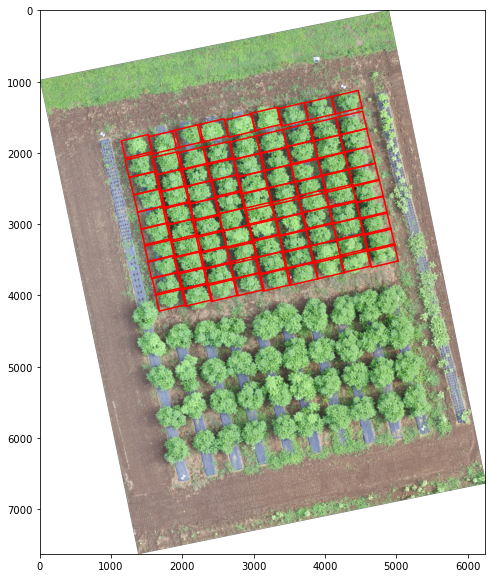

In [127]:
# before rotation
converted_coords = []
for geom in shapefile.geometry:
    converted_coord = []
    coords = list(geom.exterior.coords)
    for coord in coords:
        y, x = rasterio.transform.rowcol(transform, coord[0], coord[1])
        converted_coord.append([x,y])       
    converted_coords.append(converted_coord)

plt.figure(figsize=(10,10))
plt.imshow(rgba)
for idx, coords in enumerate(converted_coords):
    p1, p2, p3, p4, p5 = coords
    plt.plot([p1[0], p2[0], p3[0], p4[0], p5[0]],
                [p1[1], p2[1], p3[1], p4[1], p5[1]],
                color='red')

In [116]:
def calculate_rotation_angle(pt1, pt2):
    dx = pt2[0] - pt1[0]
    dy = pt2[1] - pt1[1]
    angle_radians = np.arctan2(dy, dx)
    angle_degrees = np.degrees(angle_radians)
    rotation_angle = 0 - angle_degrees
    
    # Determine the optimal (smallest) rotation angle
    if abs(rotation_angle) > 90:
        rotation_angle = 180 + rotation_angle
    
    return rotation_angle

def rotate_points(points, center, angle_deg):
    # Convert angle to radians
    theta = np.radians(angle_deg)
    
    # Define the rotation matrix
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    
    # Subtract the center, rotate, then add the center back
    rotated_points = np.dot(points - center, R.T) + center
    
    return rotated_points

def approximate_rectangle(points):
    # Convert points to a contour format required by OpenCV
    contour = points.reshape((-1, 1, 2)).astype(np.int32)
    
    # Approximate the contour to a rectangle
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    xmin = np.min(box[:, 0])
    xmax = np.max(box[:, 0])
    ymin = np.min(box[:, 1])
    ymax = np.max(box[:, 1])
    bbox = np.array([xmin, ymin, xmax, ymax], dtype=np.int32)
    return bbox

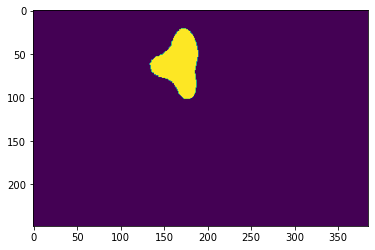

In [136]:
results = {}

rgb = rgba[..., :3].copy()
h, w = rgb.shape[:2]
for idx, coords in enumerate(converted_coords):
    results[idx] = {}
    p1, p2, p3, p4, p5 = coords
    points = np.array([p1,p2,p3,p4])
    
    
    # Calculate the rotation matrix and rotate the image only for the first polygon
    if idx == 0:
        center_float = (float(w/2), float(h/2))
        # Get the rotation matrix
        angle_deg = calculate_rotation_angle(points[0], points[1])
        M = cv2.getRotationMatrix2D(center_float, -angle_deg, 1.0)
        # Rotate
        rotated_rgb = cv2.warpAffine(rgb, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
        rotated_dsm = cv2.warpAffine(dsm, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=255)
    
    # Rotate the points and get the bounding box
    rotated_points = rotate_points(points, center_float, angle_deg)
    bbox = approximate_rectangle(rotated_points)
    # Get the crop
    cropped_rgb = rotated_rgb[bbox[1]:bbox[3], bbox[0]:bbox[2]].copy()
    cropped_dsm = rotated_dsm[bbox[1]:bbox[3], bbox[0]:bbox[2]].copy()
    # filer by depth
    idx_n0 = np.where(cropped_dsm != 0)
    th_1 = np.ptp(cropped_dsm[idx_n0])  # ptp computes the range (difference between max and min)
    thresh = cropped_dsm[idx_n0].min() + th_1 * 0.4
    depth_mask = cropped_dsm > thresh
    # filter by lab
    lab = cv2.cvtColor(cropped_rgb, cv2.COLOR_RGB2LAB)[...,1]
    lab_mask = lab < 116
    mask = depth_mask & lab_mask
    
    # calculate plant height
    # mask cropped_dsm with mask
    cropped_dsm = cropped_dsm * mask
    # get non zero values of cropped_dsm and filter it to
    idx_n0 = np.where(cropped_dsm != 0)
    # get the values of cropped_dsm where idx_n0 is true
    values = cropped_dsm[idx_n0]
    # get the 95th percentile of values which should be used for height calculation
    plant_height = np.percentile(values, 95)
    results[idx]['plant_height'] = plant_height
    
    # calculate coverage
    lbl = label(mask)
    props = regionprops(lbl)
    idx = np.argmax([prop.area for prop in props])
    prop = props[idx]
    area = prop.area
    results[idx]['coverage'] = area
    
    # plt.imshow(cropped_rgb)
    # plt.imshow(mask,alpha=0.5)
    # plt.show()
    break

In [119]:
matlab_a = -11.0368
a_thresh = ((matlab_a + 128) / 255) * 255
a_thresh = int(a_thresh)
print(a_thresh)

116


```matlab
>> view(DTSMmodel)

分類の決定木
1  A1<-11.0368 の場合はノード 2、A1>=-11.0368 の場合はノード 3、それ以外の場合は background
2  class = vegetation
3  class = background

```
